In [1]:
import xarray as xr
import xesmf as xe
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

In [2]:
import os
import sys
module_path_lupft = '/home/glemieux/Repos/NGEET/fates/tools/landuse/src/landusepft/'
sys.path.append(module_path_lupft)
from landusepftmod import ImportLandusePFTFile, ImportStaticLUH2File
from landusepftmod import RenormalizePFTs, AddLatLonCoordinates, DefineMask
module_path_luh2 = '/home/glemieux/Repos/NGEET/fates/tools/luh2/'
sys.path.append(module_path_luh2)
from luh2mod import SetMaskSurfData, SetMaskLUH2

In [3]:
def plotnatpft(variable, colormap='magma_r'):
    fg = variable.plot(x='lon',y='lat',col='natpft', col_wrap=4, cmap=colormap, 
                   transform=ccrs.PlateCarree(), subplot_kws=dict(projection=ccrs.Robinson()), add_colorbar=False)

    for ax in fg.axes.flat:
        ax.coastlines() 

    # color bar
    fg.add_colorbar(orientation="vertical", shrink=0.6, anchor=(1.5, 0.5))
    plt.subplots_adjust(hspace=-0.65)

### Import data

In [4]:
luh2_static_file = '/home/glemieux/Data/luh2/staticData_quarterdeg.nc'
regrid_target_file = '/home/glemieux/Data/surfdat/surfdata_4x5_16pfts_Irrig_CMIP6_simyr2000_c170824.nc'
clm_surface_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_surf_deg025.nc'
clm_forest_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhforest_deg025.nc'
clm_pasture_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhpasture_deg025.nc'
clm_other_file = '/home/glemieux/Data/luh2/lu-pft/CLM5_current_luhother_deg025.nc'
filelist = [clm_surface_file, clm_forest_file, clm_pasture_file, clm_other_file]

In [5]:
ds_landusepfts = []
for filename in filelist:
    ds_landusepfts.append(ImportLandusePFTFile(filename))

In [6]:
ds_static = ImportStaticLUH2File(luh2_static_file)

In [7]:
ds_target = xr.open_dataset(regrid_target_file)
ds_target = ds_target.rename_dims(dims_dict={'lsmlat':'lat','lsmlon':'lon'})
ds_target['lon'] = ds_target.LONGXY.isel(lat=0)
ds_target['lat'] = ds_target.LATIXY.isel(lon=0)

### Prep data

In [8]:
# mask_static = DefineMask(ds_static)
# mask_static = 1. - ds_static.icwtr

In [8]:
ds_target = SetMaskSurfData(ds_target)

In [9]:
for dataset in ds_landusepfts:
    AddLatLonCoordinates(dataset)

### Calculate bareground percentage

In [10]:
percent = []
percent_bareground = ds_landusepfts[0].PCT_NAT_PFT.isel(natpft=0)
# percent_bareground = (percent_bareground / 100.0) * mask_static
percent_bareground = (percent_bareground / 100.0)
percent.append(percent_bareground)

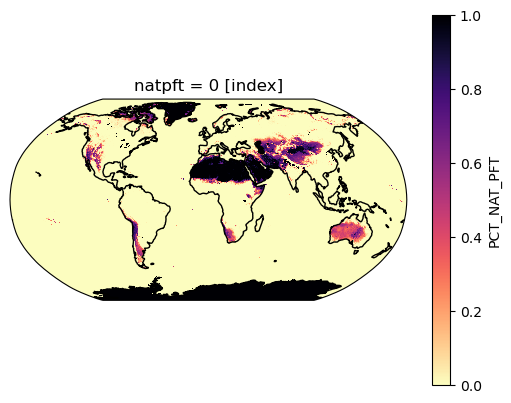

In [11]:
ax = plt.subplot(projection=ccrs.Robinson())
percent_bareground.plot(cmap='magma_r', transform=ccrs.PlateCarree())
ax.coastlines()

### Try regridding just the bareground

In [12]:
ds_bareground = percent_bareground.to_dataset(name='frac_bareground')
ds_bareground = SetMaskLUH2(ds_bareground,ds_static)

In [13]:
regridder_baseonly = xe.Regridder(ds_bareground, ds_target, "conservative")
ds_regrid_bareground = regridder_baseonly(ds_bareground)

/home/glemieux/local/miniconda3/envs/jupyter-luh2/lib/python3.10/site-packages/xesmf/backend.py:56: UserWarning: Latitude is outside of [-90, 90]
  warnings.warn('Latitude is outside of [-90, 90]')


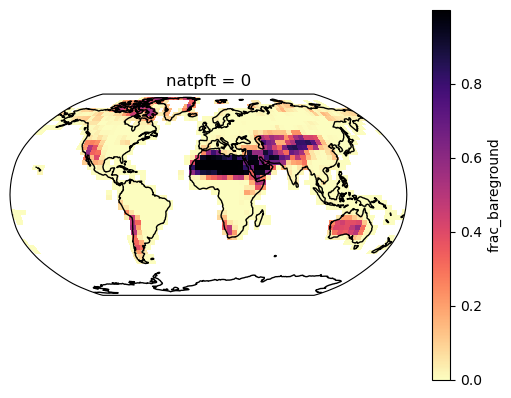

In [14]:
ax = plt.subplot(projection=ccrs.Robinson())
ds_regrid_bareground.frac_bareground.plot(cmap='magma_r', transform=ccrs.PlateCarree())
ax.coastlines()

### Renormalize the PCT_NAT_PFT for each dataset using the mask

In [11]:
for data_array in ds_landusepfts:
    percent.append(RenormalizePFTs(data_array, mask_static))

### Calculate the primary and secondary PFT fractions as the forest

In [12]:
percent[2] = ds_static.fstnf * percent[2] + (1. - ds_static.fstnf) * percent[-1]

/tmp/ipykernel_33417/941046407.py:5: DeprecationWarning: self.axes is deprecated since 2022.11 in order to align with matplotlibs plt.subplots, use self.axs instead.
  for ax in fg.axes.flat:


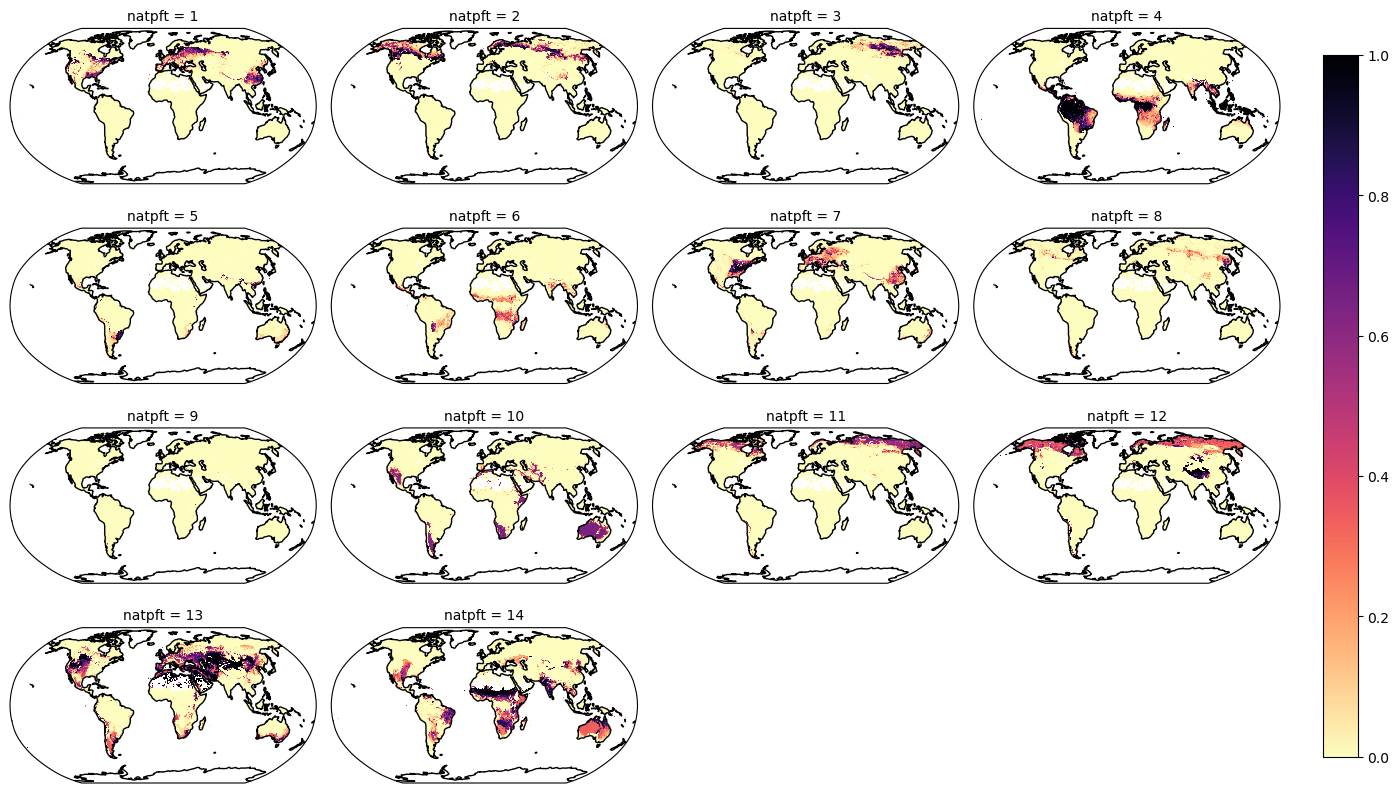

In [13]:
plotnatpft(percent[2])